In [42]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, isa_vit_metric, Tracker

In [43]:
rpn_tk = Tracker()

### Monitoring and CUDA Setup


In [44]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_21_2024_082717'

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [46]:
rpn_tk.date = rn
rpn_tk.logfile = f'rpn_vit_{dte}.log'
rpn_tk.device = device

### Config for RPN and ViT Fitter


In [47]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        global_context=True,
        nh=4,
        pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.SmoothL1Loss(),
    'lr': 0.0001
}

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [48]:
rpn_tk.model = 'RPN'
rpn_tk.model_hyperparams = rpn_config['model'].config
rpn_tk.uses_resnet = rpn_config['model'].config['pretrained']
rpn_tk.optimizer = f"{rpn_config['optimizer']}"
rpn_tk.epochs = rpn_config['epochs']
rpn_tk.loss = f"{rpn_config['loss']}"
rpn_tk.lr = rpn_config['lr']

### Dataset Loading


In [49]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [50]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
rpn_tk.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [51]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 rpn_tracker=rpn_tk,
                ):
    if cohort == 1:
        rpn_tracker.cohort1 = True
    if cohort == 2:
        rpn_tracker.cohort2 = True
    if cohort == 3:
        rpn_tracker.cohort3 = True
    
    rpn_tracker.test_size = test_size
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### RPN Fitter


In [52]:
from project import Fitter

In [53]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                # x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    # x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

### Train-Test Split


In [54]:
rpn_t1, rpn_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=True
)

rpn_t3, rpn_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=True
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [55]:
from torch.utils.data import ConcatDataset

rpn_train_set = ConcatDataset([rpn_t1, rpn_t3])
rpn_test_set = ConcatDataset([rpn_v1, rpn_v3])

print(f'RPN Train Set Size: {rpn_train_set}')
print(f'RPN Test Set Size: {rpn_test_set}')

RPN Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x00000130E62C6C10>
RPN Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x00000131E7825650>


In [56]:
batchs = 20

rpn_test_dataloader = DataLoader(
    rpn_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [57]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [59]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 32

In [60]:
rpn_test_iou = []
rpn_test_precision = []
rpn_test_recall = []
rpn_test_f1 = []

In [61]:
rpn_fold_metrics = []

fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(rpn_train_set)):
    print(f'Fold {i + 1}/{5}')
    logger.info(f'################################### Fold {i+1}/5 ###################################')
    
    # RPN
    rpn_config['model'] = RPN(**rpn_tk.model_hyperparams).to(device)
    
    rpn_fitter = RPNFitter(rpn_config, logger=logger)
    
    rpn_train_subset = Subset(rpn_train_set, train_index)
    rpn_val_subset = Subset(rpn_train_set, val_index)

    rpn_tk.batch_size = 2
    
    rpn_train_subset_dl = DataLoader(
        rpn_train_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_val_subset_dl = DataLoader(
        rpn_val_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_thist, rpn_vhist, rpn_tmhist, rpn_vmhist = rpn_fitter.fit(rpn_train_subset_dl, rpn_val_subset_dl)
    
    rpn_fold_metrics.append({
        'fold': i + 1,
        'training_history': rpn_thist,
        'validation_history': rpn_vhist,
        'training_metrics': rpn_tmhist,
        'validation_metrics': rpn_vmhist
    })
    
    rpn_h, rpn_mh = rpn_fitter.validation(rpn_test_dataloader)
    rpn_valmets = pd.DataFrame(rpn_mh)
    rpn_mets = rpn_valmets.mean()
    
    rpn_test_iou.append(rpn_mets.iou_score)
    rpn_test_precision.append(rpn_mets.precision_score)
    rpn_test_recall.append(rpn_mets.recall_score)
    rpn_test_f1.append(rpn_mets.f1_score)
    
    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(rpn_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/rpn_fold{i+1}.pt')

    

INFO:kess:################################### Fold 1/5 ###################################


Fold 1/5


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.053099554032087326

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.054603081196546555

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.06340304762125015

INFO:kess:Batch:	4/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.024322018027305603

INFO:kess:Batch:	5/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.04772282764315605

INFO:kess:Batch:	6/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01301

Fold 2/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.030216660350561142

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.032405950129032135

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.04247542843222618

INFO:kess:Batch:	4/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.026696836575865746

INFO:kess:Batch:	5/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.008649244904518127

INFO:kess:Batch:	6/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.013819864019751549

INFO:kess:Batch:	7/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.023461155593395233

INFO:kess:Batch:	8/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.006472822744399309

INFO:kess:Batch:	9/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01301009301096201

INFO:kess:Batch:	10/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.025971289724

Fold 3/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.05692003667354584

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.037930551916360855

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.04276297986507416

INFO:kess:Batch:	4/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.058491431176662445

INFO:kess:Batch:	5/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.02837945707142353

INFO:kess:Batch:	6/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.022775590419769287

INFO:kess:Batch:	7/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.020512834191322327

INFO:kess:Batch:	8/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.021642979234457016

INFO:kess:Batch:	9/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.024331314489245415

INFO:kess:Batch:	10/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.0117231151089

Fold 4/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.03151773661375046

INFO:kess:Batch:	2/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.024027936160564423

INFO:kess:Batch:	3/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.03282153233885765

INFO:kess:Batch:	4/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.022667016834020615

INFO:kess:Batch:	5/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.02385825477540493

INFO:kess:Batch:	6/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01788916438817978

INFO:kess:Batch:	7/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.011040836572647095

INFO:kess:Batch:	8/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.015236261300742626

INFO:kess:Batch:	9/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.007878433912992477

INFO:kess:Batch:	10/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01165375020354

Fold 5/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.010982844978570938

INFO:kess:Batch:	2/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.00933834258466959

INFO:kess:Batch:	3/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.013489605858922005

INFO:kess:Batch:	4/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.006674045231193304

INFO:kess:Batch:	5/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.02524648793041706

INFO:kess:Batch:	6/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.017438489943742752

INFO:kess:Batch:	7/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.010542821139097214

INFO:kess:Batch:	8/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.015940267592668533

INFO:kess:Batch:	9/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.024290747940540314

INFO:kess:Batch:	10/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.033448517322

In [62]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [64]:
def plot_metric_history(fold_metrics, metric, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(len(rpn_fold_metrics)):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        sns.lineplot(x=range(1, len(train)+1), y=train, label=f'Training {metric}', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label=f'Validation {metric}', ax=ax)
    
    
        ax.set_title(f'{title}Training and Validation {metric}: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        
    plt.tight_layout()  
    plt.show()

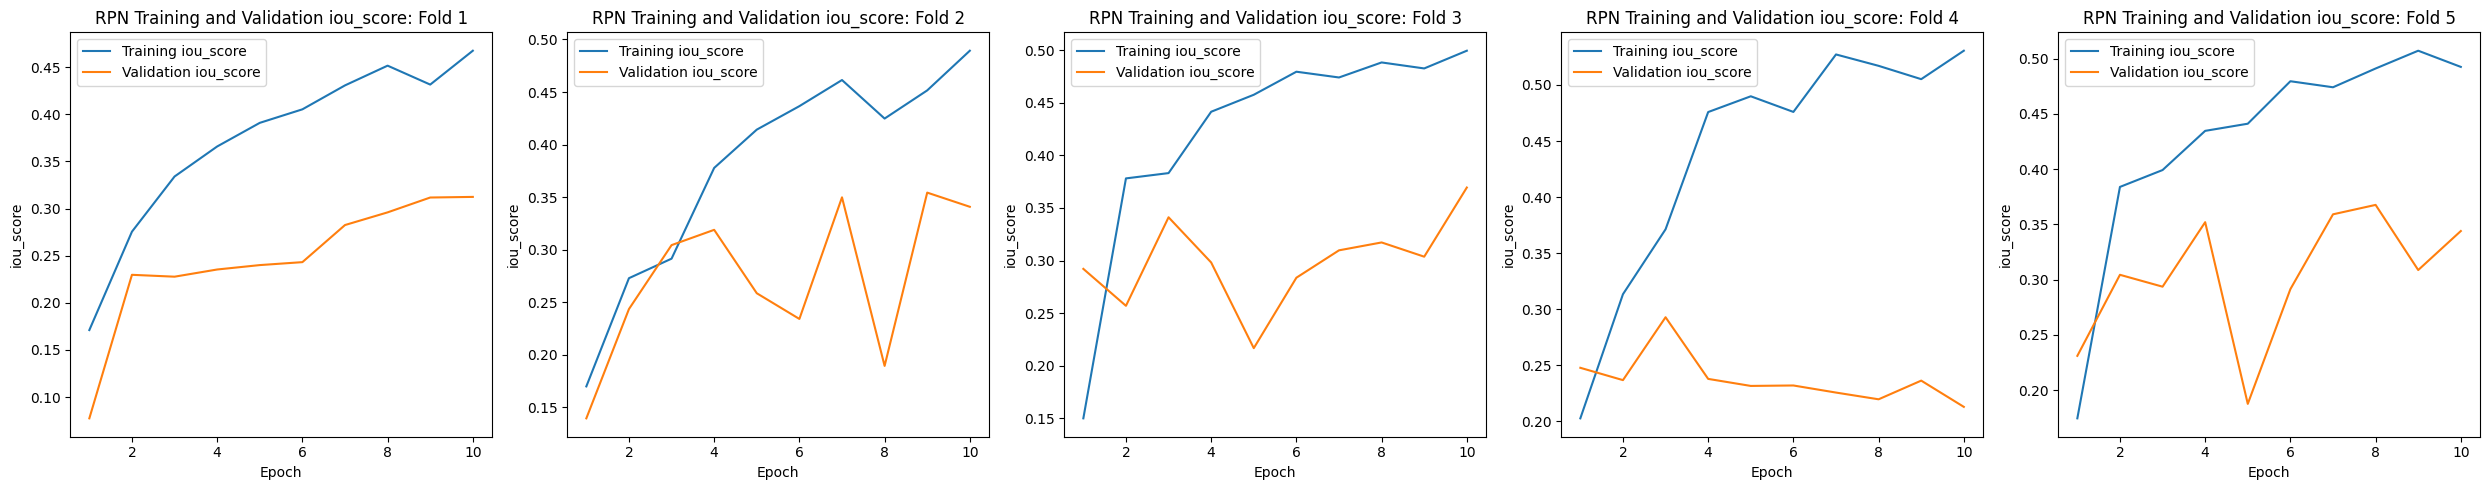

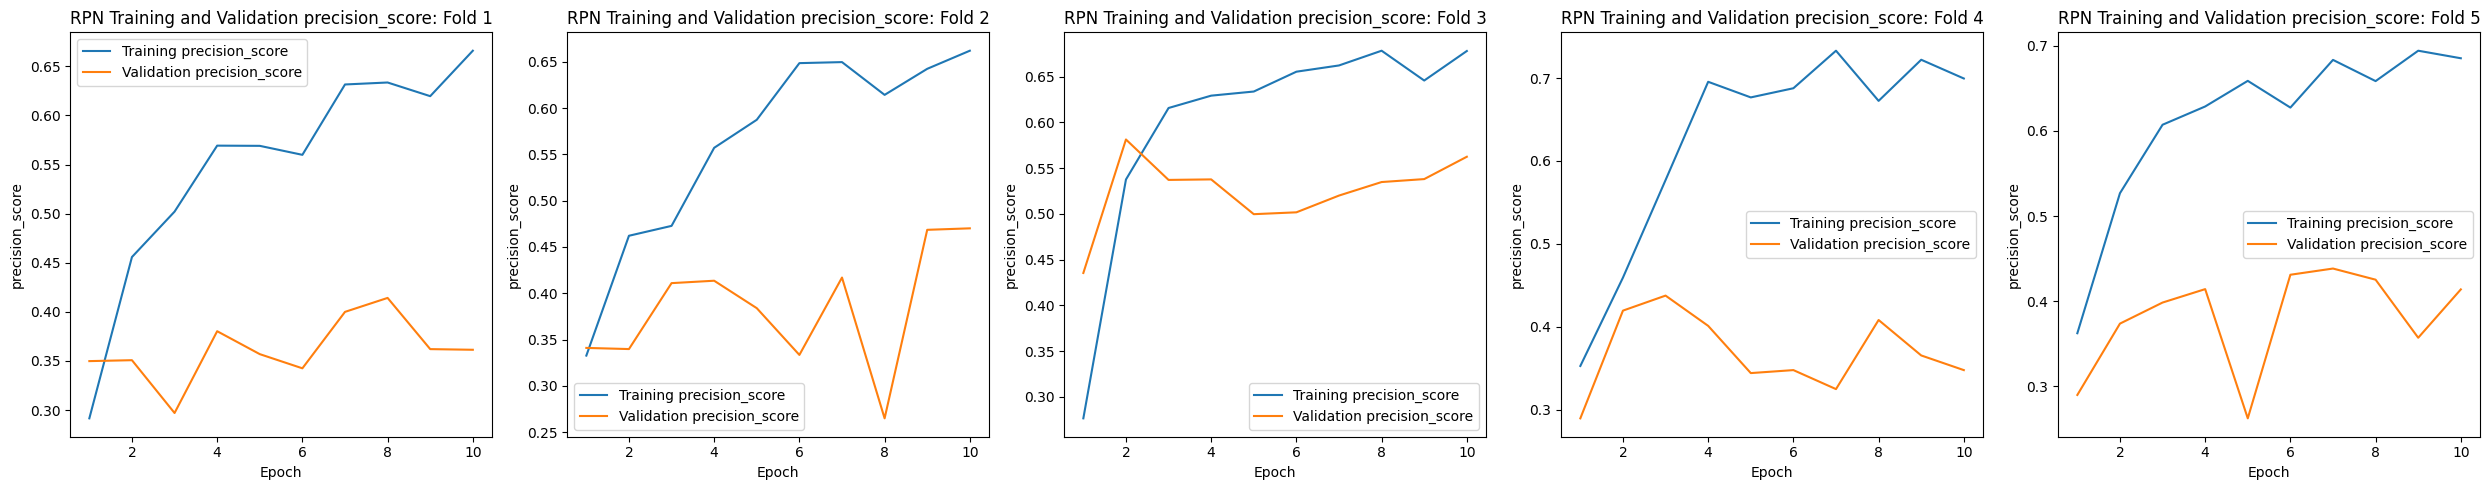

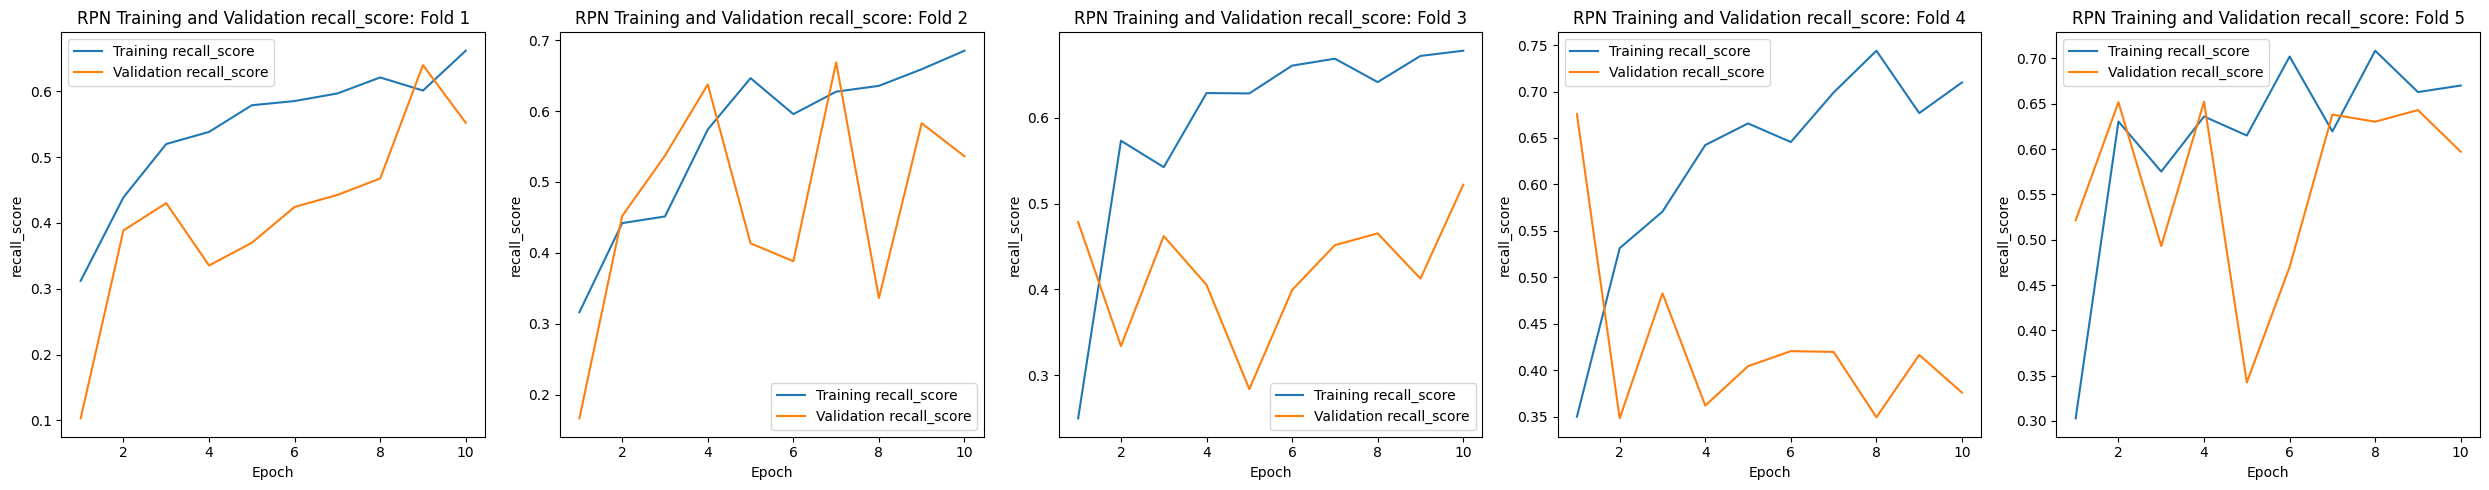

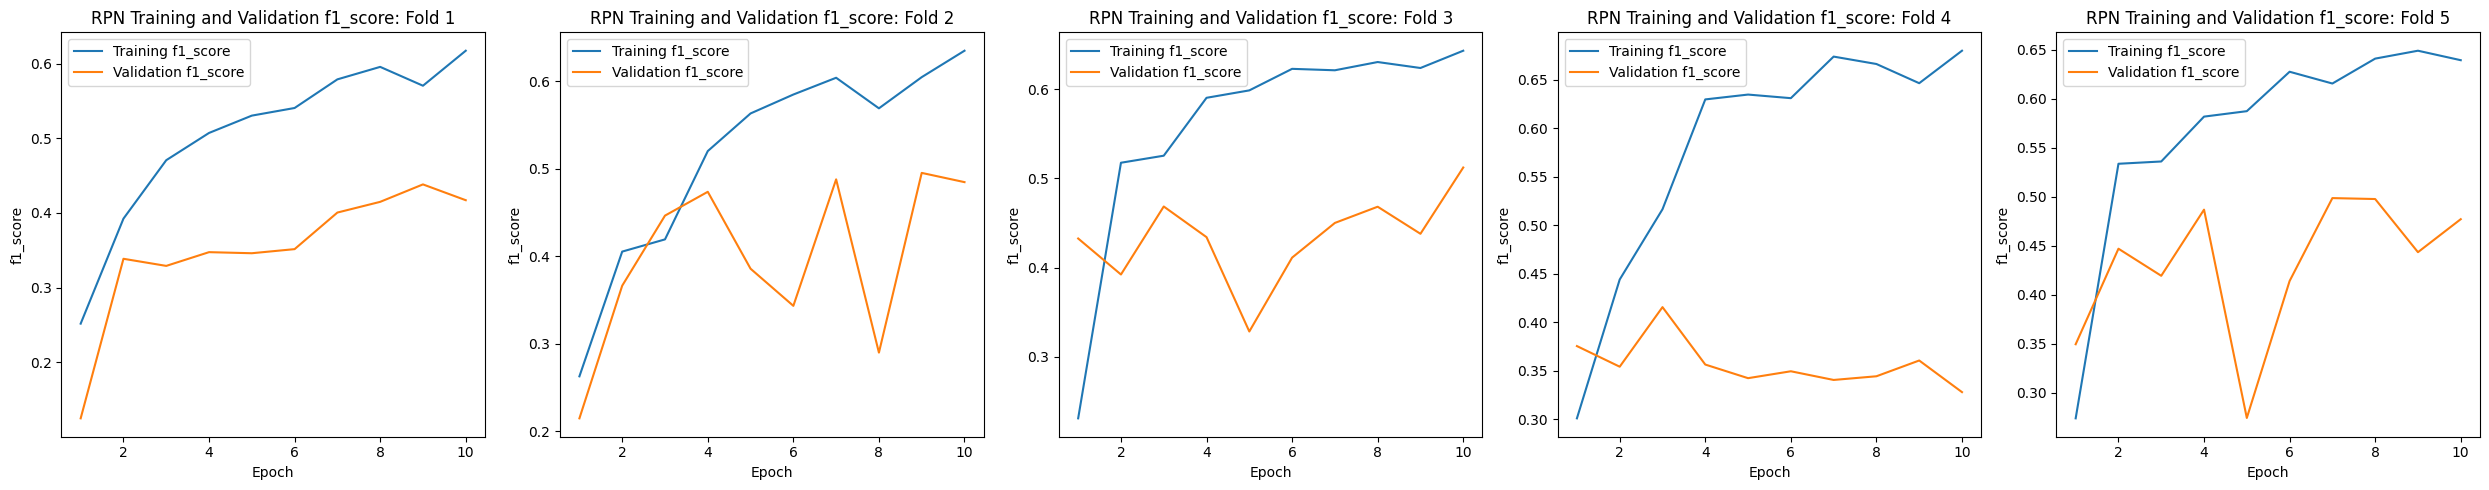

In [65]:
rpn_metrics = ['iou_score', 'precision_score', 'recall_score', 'f1_score']

for metric in rpn_metrics:
    plot_metric_history(rpn_fold_metrics, metric, 'RPN ')

### Loss History Visualization


In [66]:
def plot_loss_history(fold_metrics, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(5):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
        
        sns.lineplot(x=range(1, len(train)+1), y=train, label='Training history', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label='Validation history', ax=ax)
        
        ax.set_title(f'{title}Training and Validation History: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
    
    plt.tight_layout()  
    plt.show()

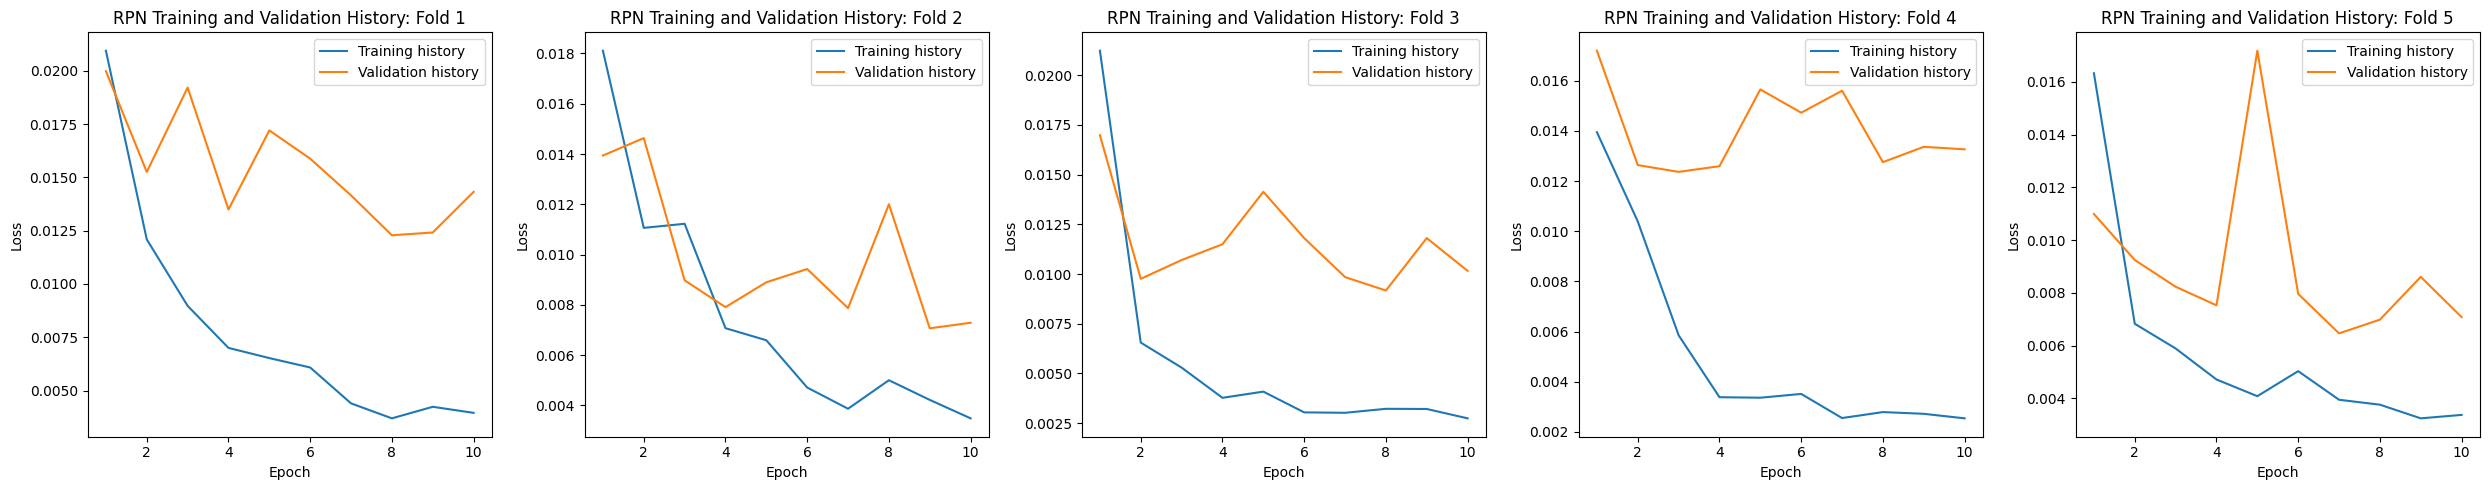

In [67]:
plot_loss_history(rpn_fold_metrics, 'RPN ')
# plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### RPN


In [68]:
df_rpn_metrics = pd.DataFrame(columns=['fold', 'iou', 'precision', 'recall', 'f1'])
df_rpn_metrics

,fold,iou,precision,recall,f1


In [69]:
df_rpn_metrics['fold'] = [1, 2, 3, 4, 5]
df_rpn_metrics['iou'] = rpn_test_iou
df_rpn_metrics['precision'] = rpn_test_precision
df_rpn_metrics['recall'] = rpn_test_recall
df_rpn_metrics['f1'] = rpn_test_f1

In [70]:
rpn_tk.iou = df_rpn_metrics.iou.mean()
rpn_tk.precision = df_rpn_metrics.precision.mean()
rpn_tk.recall = df_rpn_metrics.recall.mean()
rpn_tk.f1 = df_rpn_metrics.f1.mean()

In [71]:
df_rpn_metrics

,fold,iou,precision,recall,f1
0,1,0.303375,0.399230,0.493705,0.422404
1,2,0.323747,0.454232,0.525066,0.467243
2,3,0.358483,0.490671,0.604979,0.498756
3,4,0.314259,0.452497,0.511872,0.447316
4,5,0.347867,0.480885,0.556054,0.491927


In [72]:
rpn_iou_score = np.array(rpn_test_iou).mean()
rpn_precision_score = np.array(rpn_test_precision).mean()
rpn_recall_score = np.array(rpn_test_recall).mean()
rpn_f1_score = np.array(rpn_test_f1).mean()

print('RPN Test Set Performance Metrics')
print(f'Average IOU: {rpn_iou_score} ')
print(f'Average Precision: {rpn_precision_score} ')
print(f'Average Recall: {rpn_recall_score} ')
print(f'Average F1 Score: {rpn_f1_score} ')

RPN Test Set Performance Metrics
Average IOU: 0.3295462274335717 
Average Precision: 0.45550296528166856 
Average Recall: 0.5383352252997851 
Average F1 Score: 0.46552908281354527 


In [73]:
df_rpn_metrics.to_csv(f'{fold_dir}/rpn_metrics.csv')

### Sample


#### RPN


In [74]:
rpn_sample = next(enumerate(rpn_test_dataloader))
rpn_slices, rpn_masks, rpn_target, rpn_case = rpn_sample[1][1]

In [75]:
# rpn_x = rpn_slices.squeeze(1).float().to(device)
rpn_x = rpn_slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
rpn_T = rpn_masks.squeeze(1).float().to(device)

In [76]:
rpn_y = rpn_fitter.model(rpn_x, rpn_target)
rpn_y

tensor([[0.2259, 0.2705, 0.5864, 0.6007]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [77]:
rpn_fitter.loss(rpn_y, rpn_T[rpn_target])

tensor(132.9658, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [78]:
rpn_bbox = rpn_masks[rpn_target].squeeze().cpu().long()
rpn_y = (rpn_y*300).squeeze().detach().cpu().long()

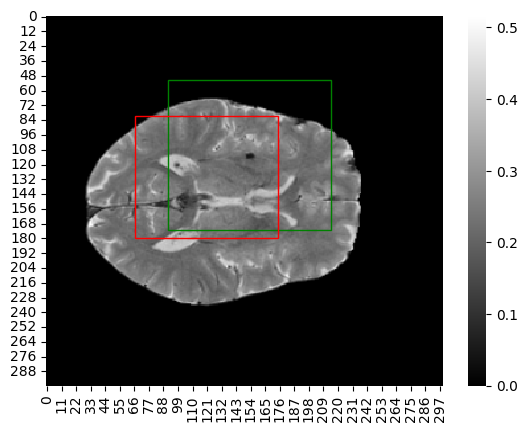

In [79]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(rpn_x[rpn_target][0].squeeze().cpu(), cmap='gray')

truth = patches.Rectangle(
    (rpn_bbox[0], rpn_bbox[1]),
    rpn_bbox[2] - rpn_bbox[0],
    rpn_bbox[3] - rpn_bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (rpn_y[0], rpn_y[1]),
    rpn_y[2] - rpn_y[0],
    rpn_y[3] - rpn_y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()

# Log Progress


In [80]:
rpn_tk.notes = '''
Global Context
'''

In [81]:
rpn_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-21 08:27:17.181350,RPN,None,None,True,True,True,False,True,<class 'torch.optim.adam.Adam'>,10,...,0.538335,0.465529,None,None,None,None,"{'input_dim': 512, 'output_dim': 4, 'image_siz...",rpn_vit_Nov_21_2024_082717.log,cuda,\nGlobal Context\n


In [82]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, rpn_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    rpn_tk().to_csv('history/runs.csv')

Merging to old df
